In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
import os
import uuid
import hashlib
from datetime import datetime
from pathlib import Path
from typing import Optional
from enum import Enum

import pixeltable as pxt
from pixeltable.iterators import AudioSplitter
from pixeltable.iterators.video import FrameIterator
from pixeltable.functions import openai, video, huggingface
from pixeltable.functions.video import extract_audio

from loguru import logger

import multimodal_mcp.video.ingestion.registry as registry
from multimodal_mcp.config import get_settings  # ✅ added for configuration import
from multimodal_mcp.video.ingestion.helper import resize_image

settings = get_settings()
logger = logger.bind(name="VideoProcessor")

In [4]:
video_table = pxt.get_table(settings.GLOBAL_VIDEO_TABLE_NAME)
video_table.show()

Connected to Pixeltable database at: postgresql+psycopg://postgres:@127.0.0.1:62257/pixeltable


video_id,video,video_name,status,processed_at,audio


In [4]:
registry.delete_registry_table()

2025-11-02 21:36:01.197 | INFO     | multimodal_mcp.video.ingestion.registry:delete_registry_table:192 - Registry table 'global_video_registry.video_registry_table' does not exist. Nothing to delete.


Connected to Pixeltable database at: postgresql+psycopg://postgres:@127.0.0.1:55870/pixeltable


In [14]:
if settings.DEFAULT_VIDEO_TABLE_DIR in pxt.list_dirs():
    pxt.drop_dir(settings.DEFAULT_VIDEO_TABLE_DIR, force=True)

if settings.GLOBAL_VIDEO_TABLE_NAME in pxt.list_tables():
    pxt.drop_table(settings.GLOBAL_VIDEO_TABLE_NAME, force=True)
    pxt.drop_table(settings.GLOBAL_AUDIO_CHUNKS_VIEW_NAME, force=True)
    pxt.drop_table(settings.GLOBAL_FRAME_VIEW_NAME, force=True)

In [6]:
from multimodal_mcp.video.ingestion.video_processor import(
    VideoProcessor
)

video_processor = VideoProcessor()

2025-11-02 21:37:03.614 | INFO     | multimodal_mcp.video.ingestion.video_processor:_ensure_dirs_and_tables_exist:58 - Created global directory global_video_table_dir
2025-11-02 21:37:03.767 | INFO     | multimodal_mcp.video.ingestion.video_processor:_ensure_dirs_and_tables_exist:74 - Created global videos table.


Created directory 'global_video_table_dir'.
Created table 'global_video_table'.


2025-11-02 21:37:03.801 | INFO     | multimodal_mcp.video.ingestion.video_processor:_process_frames:247 - Processing frames table...
2025-11-02 21:37:03.938 | INFO     | multimodal_mcp.video.ingestion.video_processor:_process_frames:259 - Created Frames view table: 'global_frames_view_table'
2025-11-02 21:37:04.068 | SUCCESS  | multimodal_mcp.video.ingestion.video_processor:_process_frames:304 - Frames Table processed.
2025-11-02 21:37:04.068 | INFO     | multimodal_mcp.video.ingestion.video_processor:_ensure_dirs_and_tables_exist:81 - Created global frames table.
2025-11-02 21:37:04.119 | INFO     | multimodal_mcp.video.ingestion.video_processor:_process_audio:189 - Processing audio...


Added 0 column values with 0 errors.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.


2025-11-02 21:37:04.262 | INFO     | multimodal_mcp.video.ingestion.video_processor:_process_audio:206 - Created Audio view table: 'global_audio_view_table'
2025-11-02 21:37:04.358 | SUCCESS  | multimodal_mcp.video.ingestion.video_processor:_process_audio:241 - Audio Table created.
2025-11-02 21:37:04.358 | INFO     | multimodal_mcp.video.ingestion.video_processor:_ensure_dirs_and_tables_exist:88 - Created global audio_chunks table.


Added 0 column values with 0 errors.
Added 0 column values with 0 errors.


In [7]:
# video_path = f"./data/pass_the_butter_rick_and_morty.mp4"
video_path = f"./data/interstellar_dont_let_me_leave.mp4"

video_processor.add_video(video_path)

2025-11-02 21:37:29.230 | INFO     | multimodal_mcp.video.ingestion.video_processor:add_video:130 - Adding video 'interstellar_dont_let_me_leave' to table.


Inserting rows into `global_video_table`: 1 rows [00:00, 72.82 rows/s]


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Inserting rows into `global_frames_view_table`: 30 rows [00:00, 376.55 rows/s]
Inserting rows into `global_audio_view_table`: 18 rows [00:00, 695.12 rows/s]
Inserted 49 rows with 0 errors.
Inserting rows into `global_video_table`: 1 rows [00:00, 124.77 rows/s]

2025-11-02 21:38:30.614 | SUCCESS  | multimodal_mcp.video.ingestion.video_processor:add_video:146 - Added video 'interstellar_dont_let_me_leave' to table.


True

video_id,video,video_name,status,processed_at,transcript_summary,audio
fd545808,,interstellar_dont_let_me_leave,done,2025-11-02 21:38:30.544870+05:00,None,

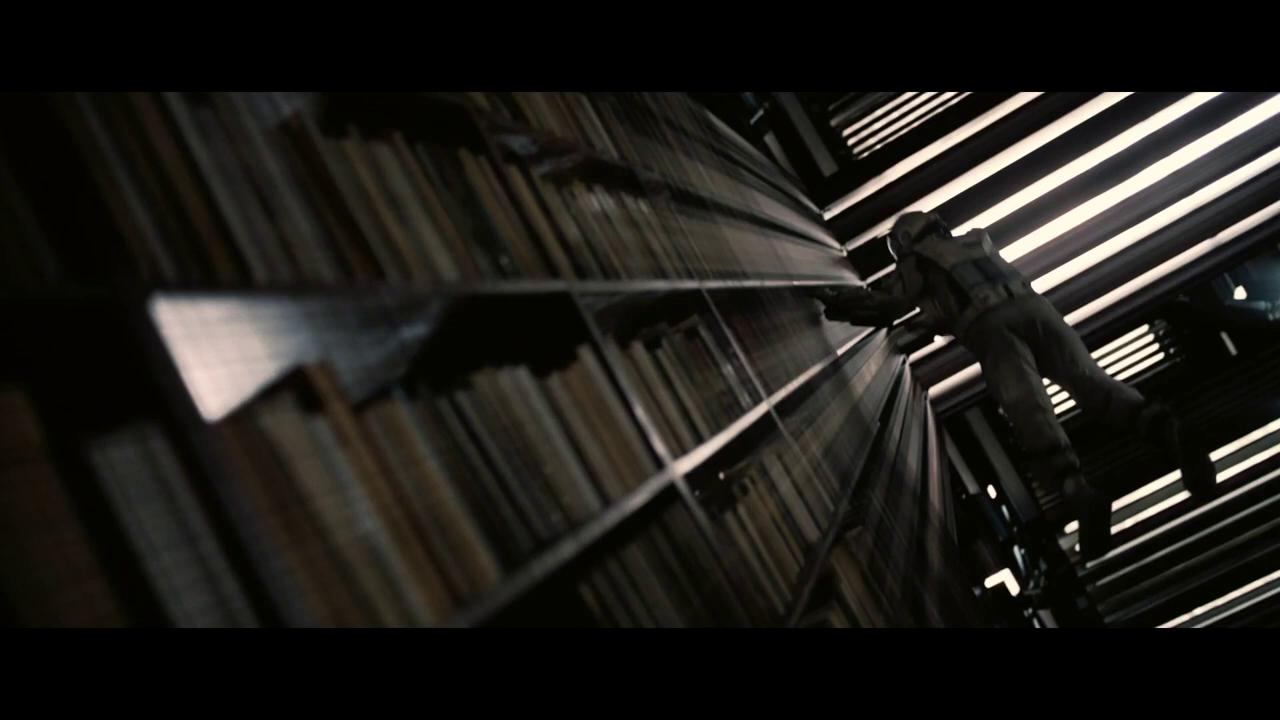

In [8]:
video_processor.video_table.show(3)

In [9]:
video_path = f"./data/interstellar_dont_let_me_leave.mp4"

video_processor.add_video(video_path)

2025-11-02 21:39:22.173 | INFO     | multimodal_mcp.video.ingestion.video_processor:add_video:105 - Video 'interstellar_dont_let_me_leave' already processed. Skipping.


False

pos,start_time_sec,end_time_sec,audio_chunk,transcription,audio_chunk_text,video_id,video,video_name,status,processed_at,transcript_summary,audio
0,0.023,10.008,,"{""text"": "" Stay!"", ""x_groq"": {""id"": ""req_01k92pyephen0t0qs2szh2f7bn""}}",Stay!,fd545808,,interstellar_dont_let_me_leave,done,2025-11-02 21:38:30.544870+05:00,None,
1,8.04,18.,,"{""text"": "" Come on. Come on, Murph. Murph. Murph, come on. What's his name? What's his name?"", ""x_groq"": {""id"": ""req_01k92pyehkfwy86jd844jaj1ja""}}","Come on. Come on, Murph. Murph. Murph, come on. What's his name? What's his name?",fd545808,,interstellar_dont_let_me_leave,done,2025-11-02 21:38:30.544870+05:00,None,
2,16.032,26.016,,"{""text"": "" What's his name? What's his name?"", ""x_groq"": {""id"": ""req_01k92pyf3ten199fw63q89p9d3""}}",What's his name? What's his name?,fd545808,,interstellar_dont_let_me_leave,done,2025-11-02 21:38:30.544870+05:00,None,

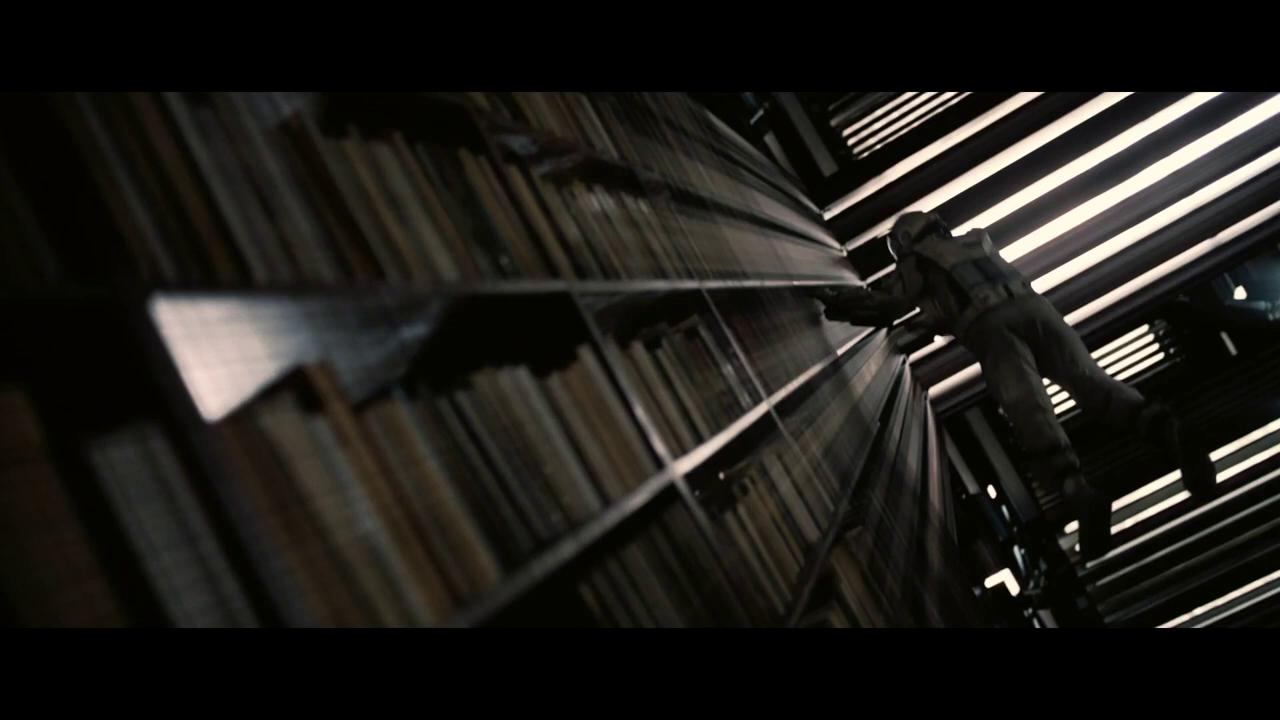
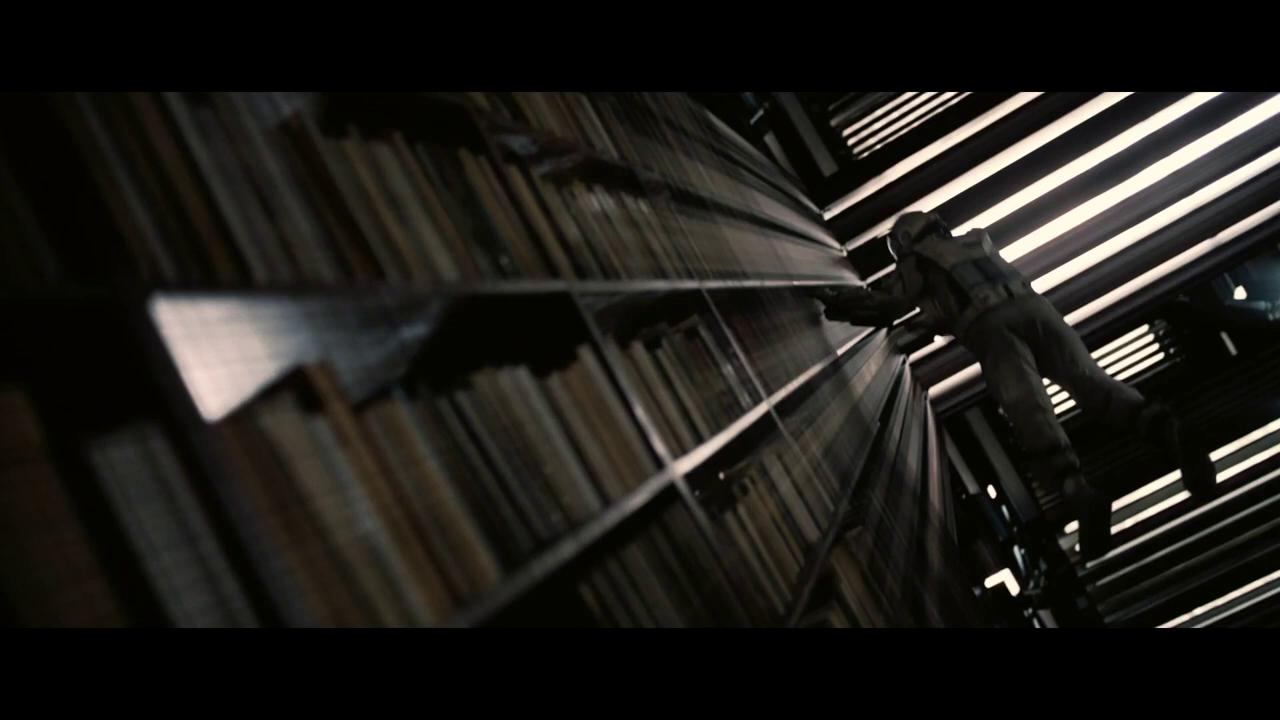
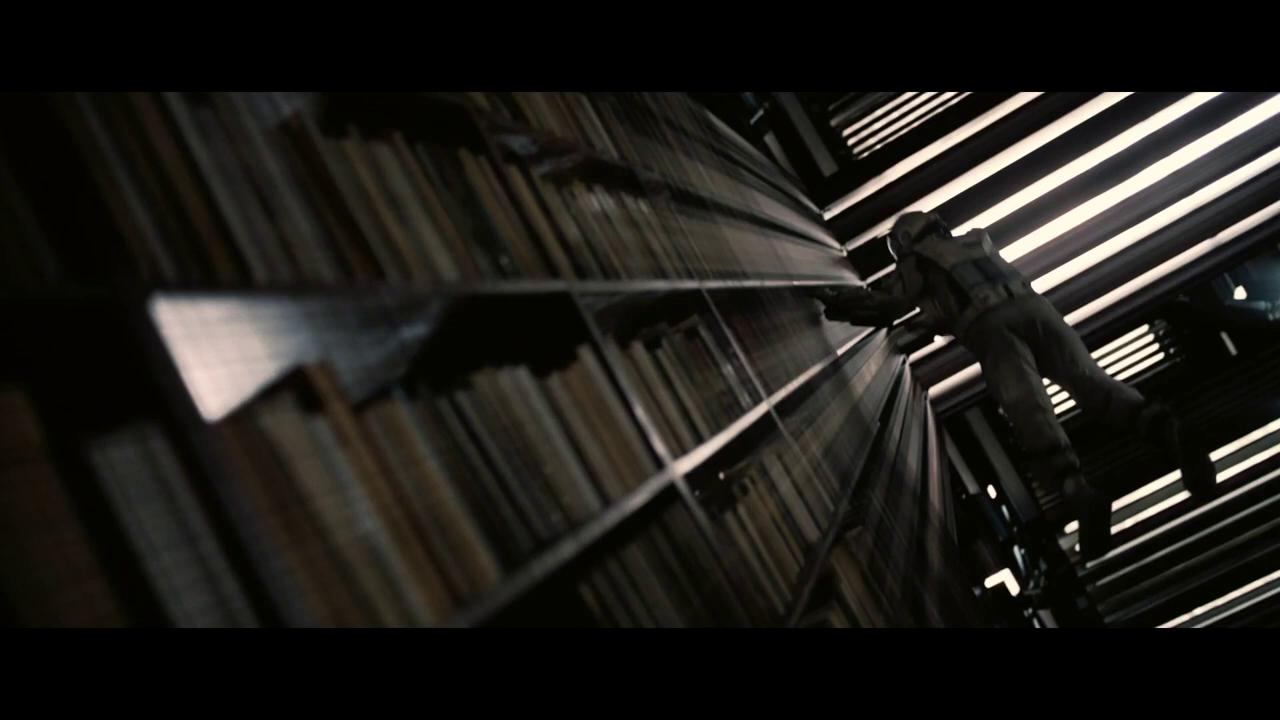

In [10]:
video_processor.audio_table.show(3)

pos,frame_idx,pos_msec,pos_frame,frame,resized_frame,caption,video_id,video,video_name,status,processed_at,transcript_summary,audio
0,0,0.,0,,None,"The image depicts a scene from a movie or television show, featuring a person climbing up a wall. The individual is dressed in dark attire and appears to be ascending a metal structure with vertical bars. **Key Elements:** * A person in dark clothing * Climbing up a wall with vertical bars * The background features a slanted roof with light shining through it **Overall Impression:** The image conveys a sense of action and suspense, suggesting that the scene may be from an intense or thrilling sequence in the movie or show.",fd545808,,interstellar_dont_let_me_leave,done,2025-11-02 21:38:30.544870+05:00,None,
1,1,4754.75,114,,None,"The image depicts an astronaut clad in a white spacesuit adorned with the American flag on the arm. The astronaut appears to be running, and the background showcases a dimly lit corridor featuring overhead fluorescent lights. The setting implies a spacecraft or a similar environment. **Key Features:** * **Astronaut's Attire:** The astronaut wears a standard white spacesuit. The presence of the American flag on the arm suggests affiliation with a U.S. space program. * **Running Posture:** The astronaut appears to be in motion, running down the corridor. This could indicate urgency or a mission-critical situation. * **Background:** The corridor's lighting and metallic appearance are typical of spacecraft interiors. * **Context:** The combination of the spacesuit and the corridor setting strongly suggests a scene from a science fiction or space exploration movie. **Conclusion:** The image likely captures a pivotal moment from a film related to space exploration or a similar genre.",fd545808,,interstellar_dont_let_me_leave,done,2025-11-02 21:38:30.544870+05:00,None,
2,2,9551.208,229,,None,"The image depicts a woman with a serious expression, likely in a movie scene. The setting appears to be a dimly lit room with a bed and a picture on the wall. The overall mood seems somber or tense.",fd545808,,interstellar_dont_let_me_leave,done,2025-11-02 21:38:30.544870+05:00,None,

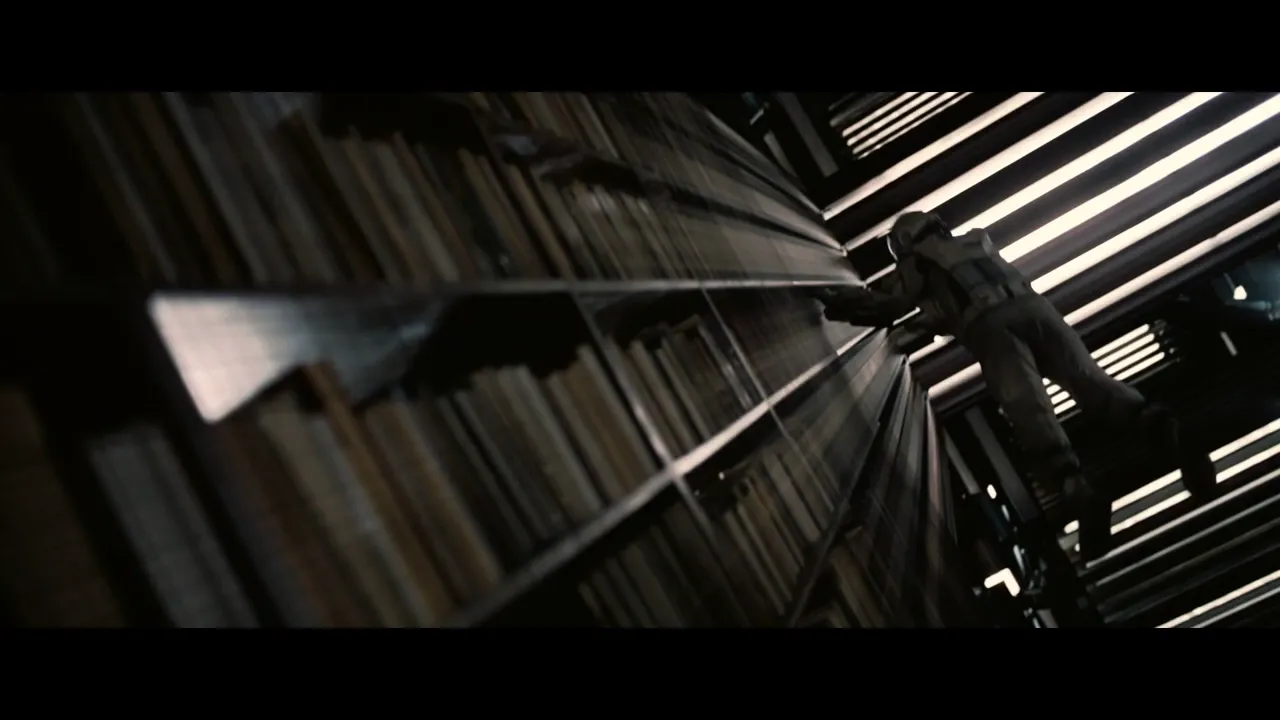
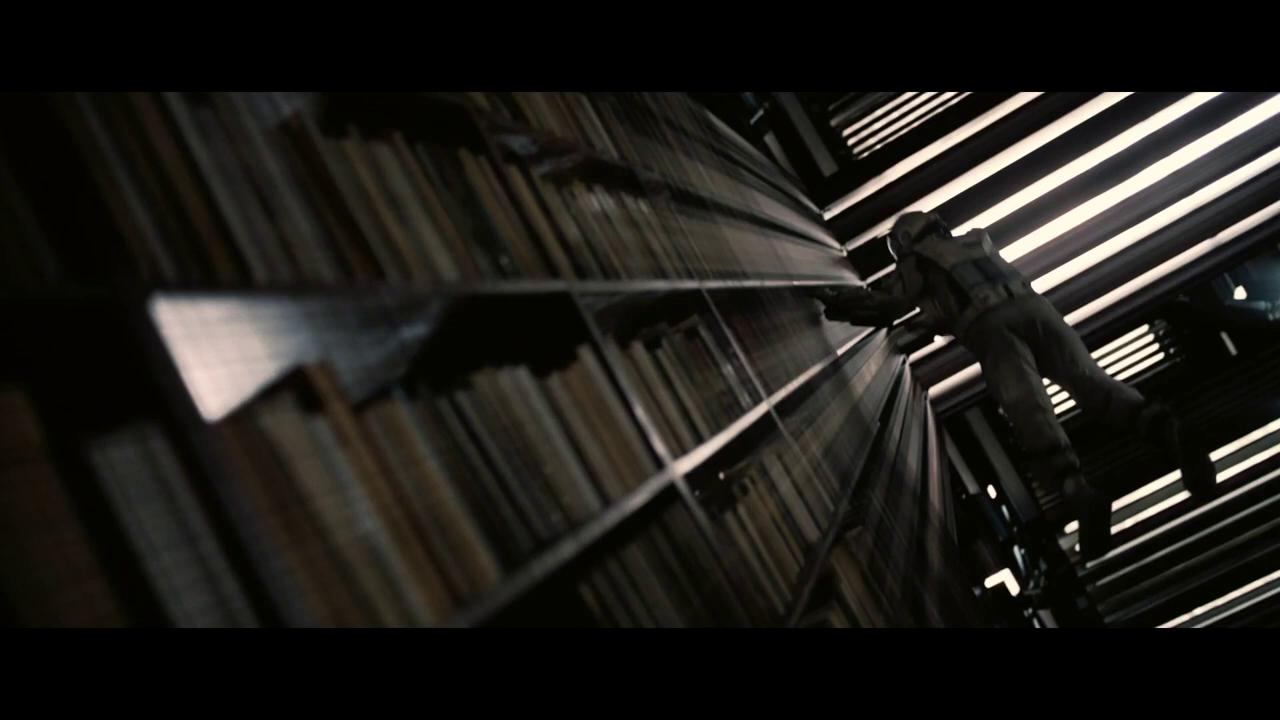
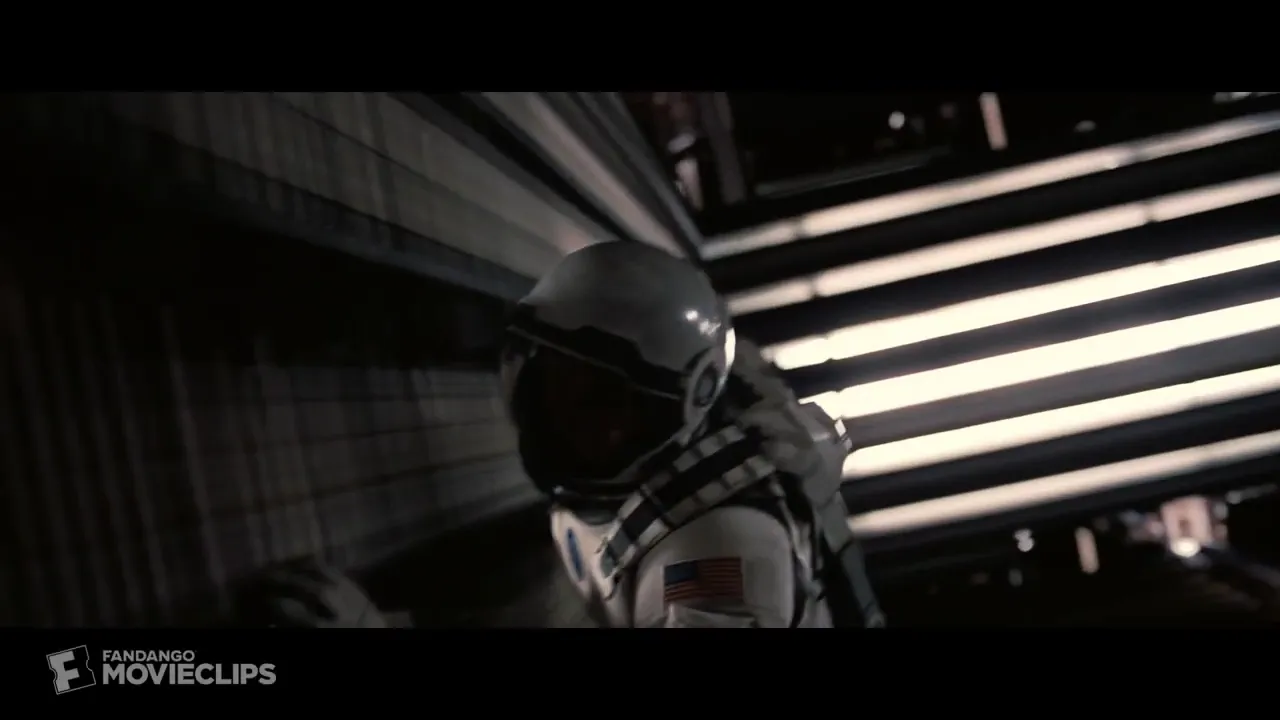
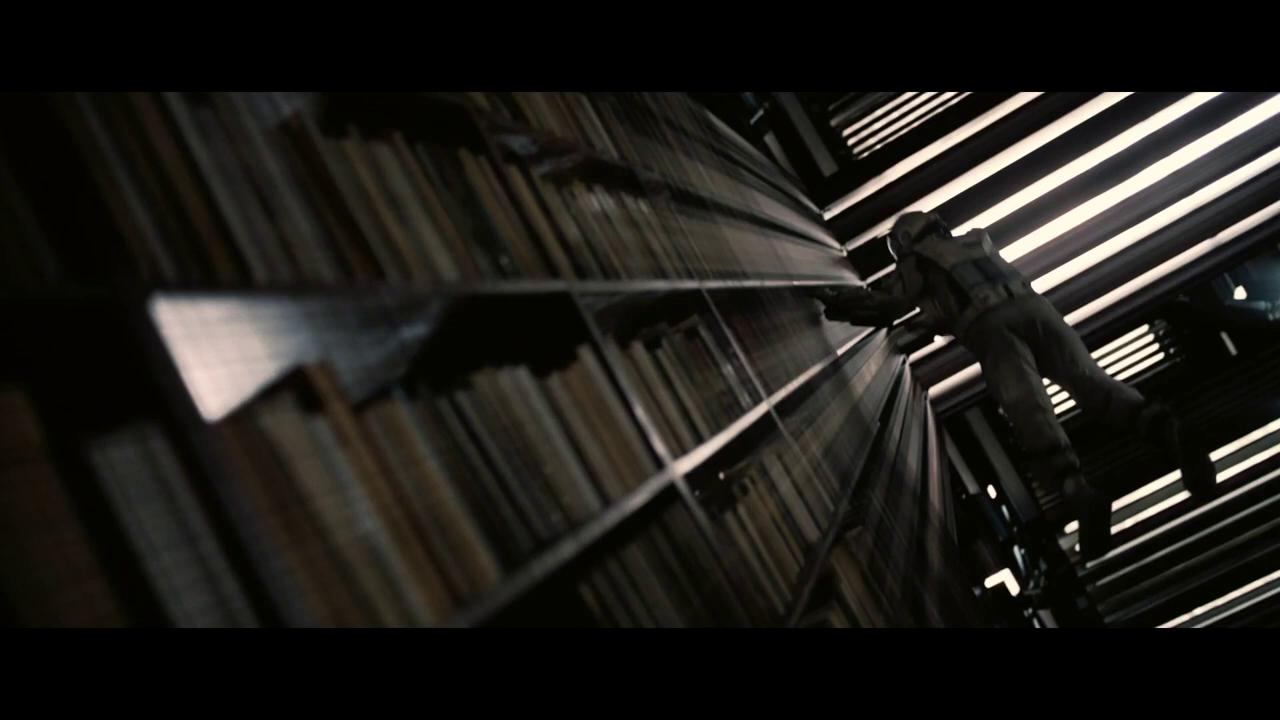
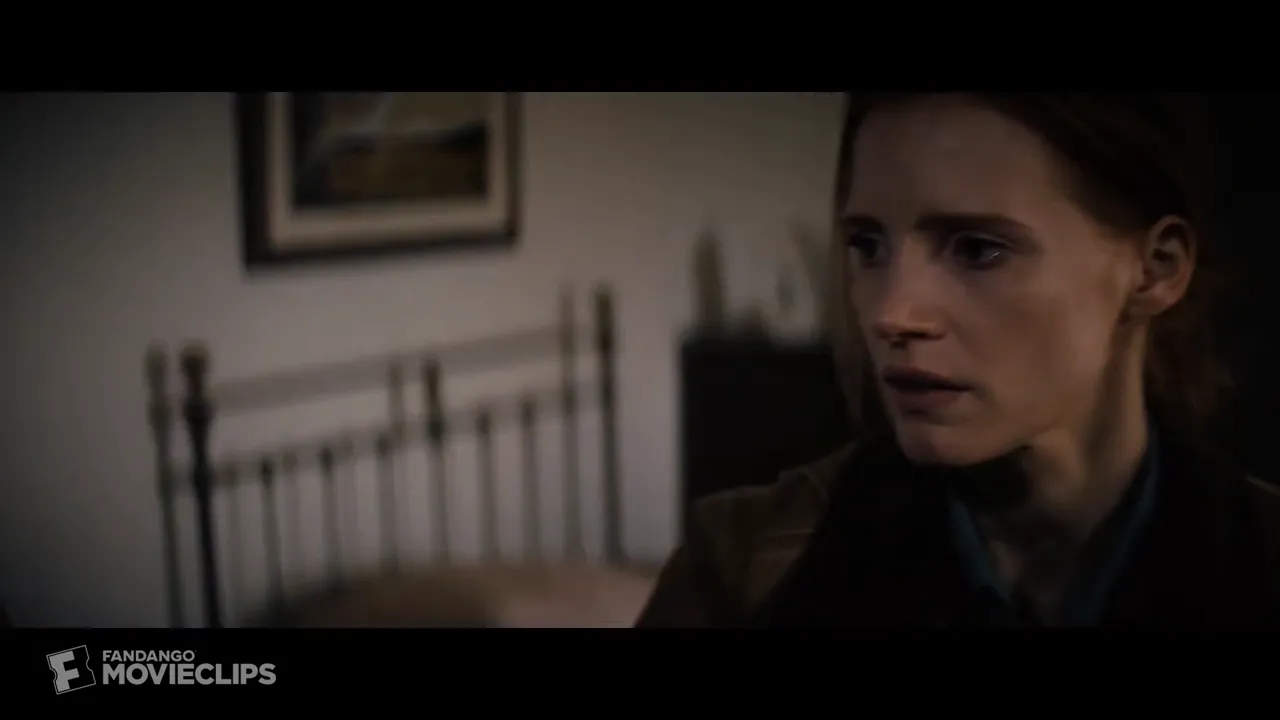
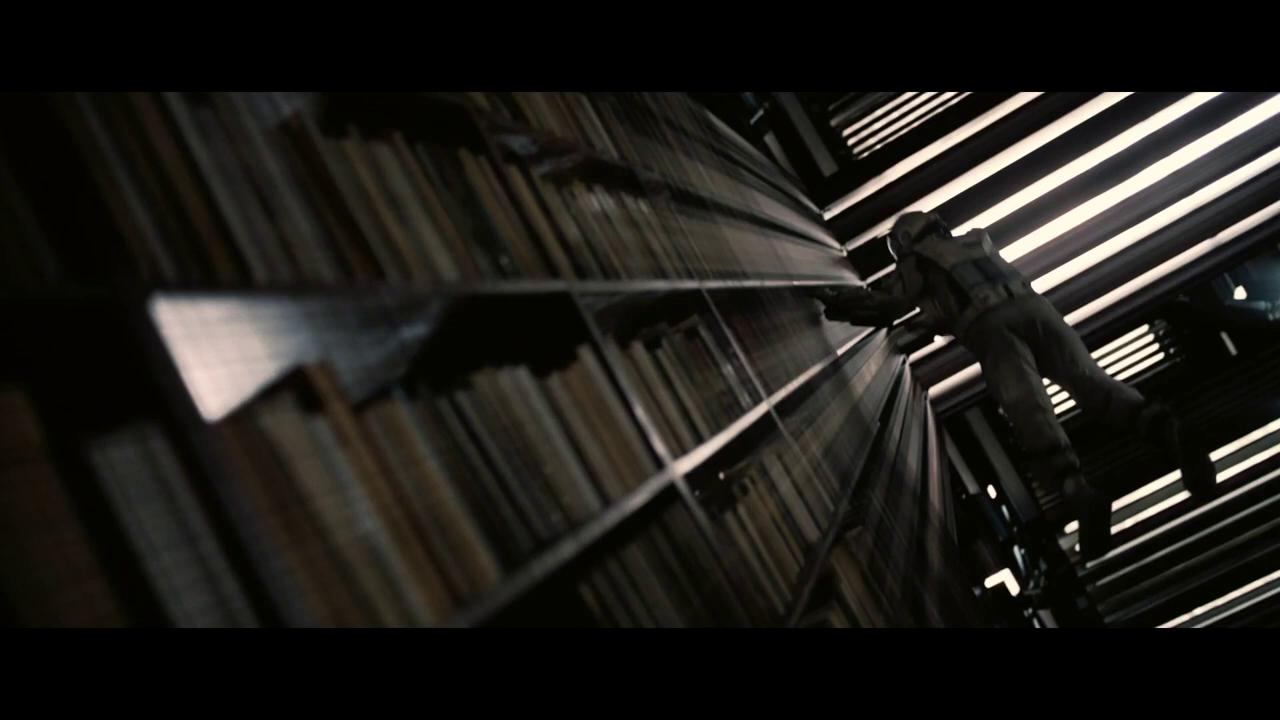

In [11]:
video_processor.frames_table.show(3)

In [12]:
video_path = f"./data/pass_the_butter_rick_and_morty.mp4"
# video_path = f"./data/interstellar_dont_let_me_leave.mp4"

video_processor.add_video(video_path)

2025-11-02 21:40:38.041 | INFO     | multimodal_mcp.video.ingestion.video_processor:add_video:130 - Adding video 'pass_the_butter_rick_and_morty' to table.


Inserting rows into `global_video_table`: 1 rows [00:00, 193.18 rows/s]
Inserting rows into `global_frames_view_table`: 30 rows [00:00, 201.26 rows/s]
Inserting rows into `global_audio_view_table`: 8 rows [00:00, 391.20 rows/s]
Inserted 39 rows with 0 errors.
Inserting rows into `global_video_table`: 1 rows [00:00, 111.10 rows/s]

2025-11-02 21:41:06.470 | SUCCESS  | multimodal_mcp.video.ingestion.video_processor:add_video:146 - Added video 'pass_the_butter_rick_and_morty' to table.


True

video_id,video,video_name,status,processed_at,transcript_summary,audio
fd545808,,interstellar_dont_let_me_leave,done,2025-11-02 21:38:30.544870+05:00,None,
f98851fc,,pass_the_butter_rick_and_morty,done,2025-11-02 21:41:06.373690+05:00,None,

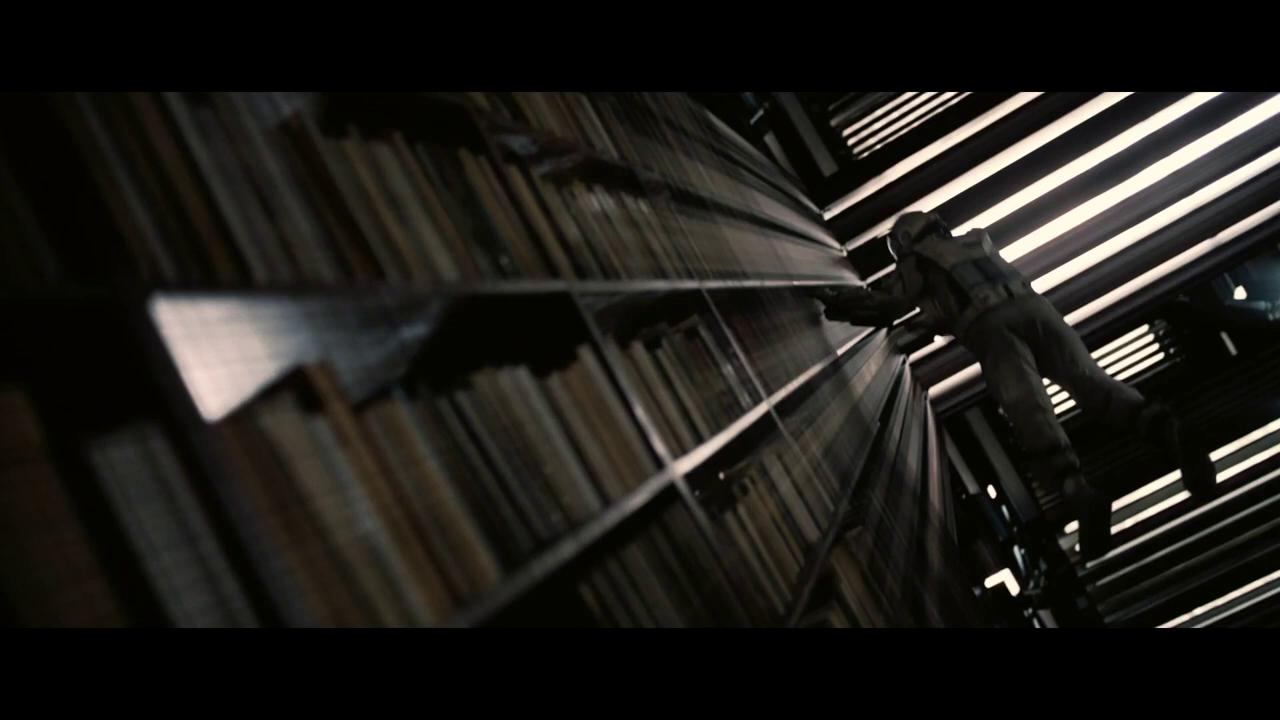
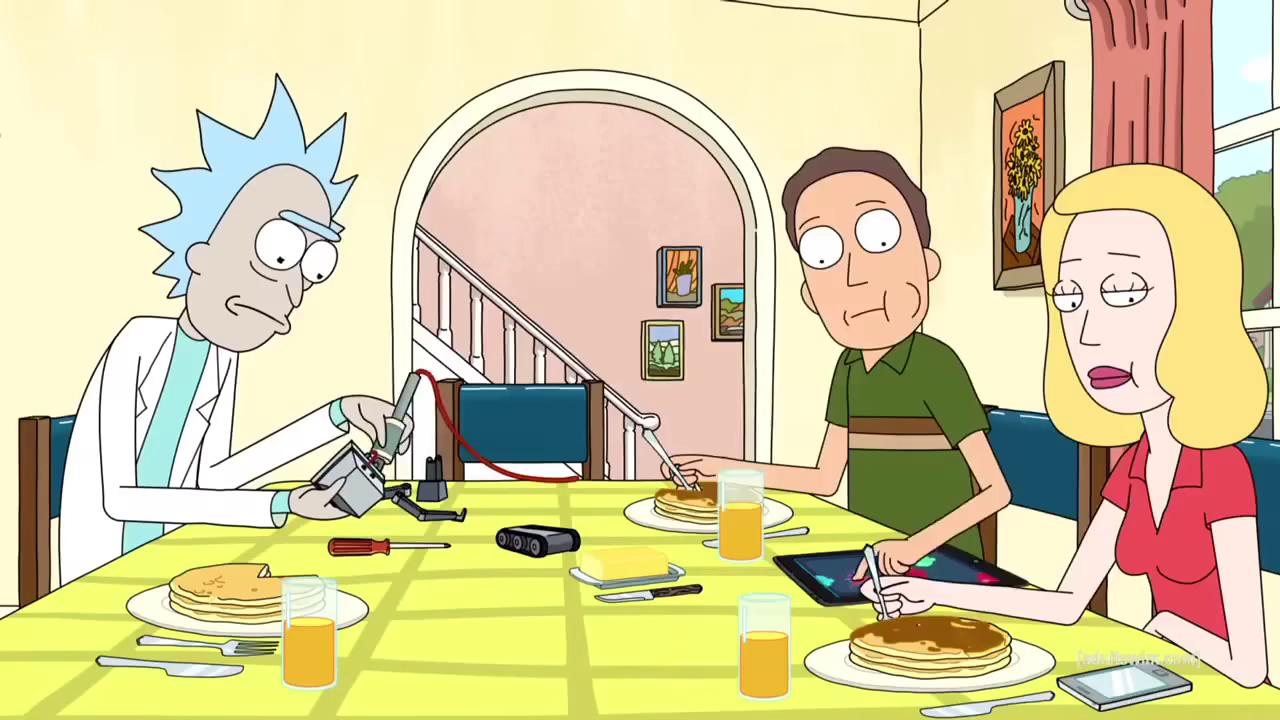

In [13]:
video_processor.video_table.show()